<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Funcionales en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Homework 03 - Diffusion Maps</div><br>
    <div style="font-size: large">María Barroso y Gloria del Valle</div><br></div><hr> 
</div>

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [1]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Exercise"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used.

In [3]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.datasets import make_blobs, make_swiss_roll, make_s_curve

from mpl_toolkits.mplot3d import Axes3D

Axes3D

matplotlib.rc("figure", figsize=(15, 5))

seed = 123
my_cmap = plt.cm.Spectral

# Introduction

This practical assignment is about implementing the manifold learning method **Diffusion Maps**, following the *scikit-learn* template for manifold learning algorithms.

We will design two main functions: one for training the algorithm, obtaining the affinity matrix and the embedded coordinates, and a second one for extending these coordinates for new patterns.

# Requirements

The objective of this assignment is to complete the class DM sketched below, which should contain at least the following methods.

`__init__(self, sigma, n_components, step=1, alpha=1)`

* This is the construction method for the class, with the following parameters:
    * `sigma`: Kernel parameter for the Gaussian kernel.
    * `n_components`: dimension of the embedding.
    * `step`: step in the Markov Chain.
    * `alpha`: density influence. It should take a value in `[0,1]`.
* This method just store the parameters in the fields of the class, to be used when needed.

`fit(self, X, y=None)`

* This is the training method, the one that performs the Diffusion Maps algorithm. 

* This method should store the affinity matrix and also the eigenvectors to computed the transformation.

`fit_transform(self, X, y=None)`

* This method returns the embedding coordinates for the training data.
* It should also store the affinity matrix and the coordinates needed to compute the transformation (for example over new, unseen patterns).

`transform(self, X)`

* This method will obtain approximated coordinates for new, unseen data points. 
* It uses for this purpose the Nyström Formula.

## Some recommendations

* It should allow to fix all the DM possibilities (different steps, density normalization...). To allow a change in the kernel function could be also a nice idea.
* Implement all the auxiliary functions that you may need, for example, for deciding the best parameter values in each case.
* It could be a nice idea to offer a deterministic output, that do not depend on the sign of the eigenvectors.

# Implementation

<div class="qst">

* Complete the `DM` class below, satisfying the described requirements.

</div>

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel, pairwise_distances
from sklearn.utils.extmath import svd_flip
from scipy.spatial import distance

In [5]:
class DM(TransformerMixin, BaseEstimator):
    """
        Diffusion Maps.
    """
    def __init__(self,
                 n_components=2,
                 kernel_type='rbf',
                 sigma='percentil',
                 step=1, 
                 alpha=1.0,
                 percentil= 50):
        # Assignment of the hyper-parameters (you can complete it).
        self.n_components = n_components
        self.kernel_type = kernel_type  # selection for affinity matrix
        self.sigma = sigma
        self.step = step
        self.alpha = alpha
        self.percentil = percentil # percentil used when sigma = 'percentil'

    def select_sigma(self):
        if self.sigma == 'percentil':
            self.sigma_ = np.percentile(pairwise_distances(self.X), self.percentil)
        elif self.sigma == 'maximum':
            self.sigma_ = np.max(pairwise_distances(self.X))
        elif self.sigma == 'auto':
            self.sigma_ = np.sqrt(self.X.shape[1]/2) # like SVM sklearn gamma = 1/n_features
        elif isinstance(self.sigma, (int, float)) and self.sigma>0.0:
            self.sigma_ = self.sigma
        else:
            raise ValueError('Please enter a correct sigma method percentil, maximun or auto or a direct positive sigma value')
        
    def compute_K(self, X, Y=None):
        if not hasattr(self, "sigma_"):
            self.select_sigma()

        if self.kernel_type == 'rbf':
            return rbf_kernel(X, Y, gamma=1/(2*self.sigma_**2))
        if self.kernel_type == 'laplacian':
            return laplacian_kernel(X, Y, gamma=1/(2*self.sigma_**2))
        else:
            raise ValueError('Please, test with rbf or laplacian kernel.')
            
        
    def fit(self, X, y=None):
        """Compute the embedding vectors for data X
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored
        Returns
        -------
        self : returns an instance of self.
        """ 
        
        # Store X for Nystrom approximation
        self.X = X
                
        # Kernel definition
        K = self.compute_K(X)
        
        # Compute Distance Diffusion
        D = (K.sum(axis=1)**self.alpha).reshape(-1,1)

        # Stationary Distribution
        pi = D / np.sum(D)

        # Transition Probability Matrix definition
            # Probability of arriving from i to j in one step
        P = K / D

        # P reduced to orthonormal basis by diagonal matrix
            # We consider its conjugated matrix A
        A = K / np.sqrt(D) / np.sqrt(D).T

        # Obtain the SVD decomposition
        eigenvectors, eigenvalues, V = np.linalg.svd(A, full_matrices=True)

        # Eigenvectors sign correction and normalization
        eigenvectors, _ = svd_flip(eigenvectors, V)
        
        # Obtain the eigenvalues and the eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(A)
        
        # Order from higher to lower discarging autovalue 1
        self.eigenvalues = eigenvalues[::-1][1:self.n_components+1]
        eigenvectors = eigenvectors[:, ::-1][:, 1:self.n_components+1]
                 
        # Compute final eigenvector of P
        self.eigenvectors = eigenvectors / np.sqrt(pi)
        
        return self

    def fit_transform(self, X, y=None):
        """Compute the embedding vectors for data X and transform X.
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored
        Returns
        -------
        X_red : array-like, shape (n_samples, n_components)
        """
        self.fit(X)
        
        # Compute the embedding
        self.embedding = (self.eigenvalues**self.step)*self.eigenvectors
        
        return self.embedding
    
    def transform(self, X):
        """Transform X.
        This function is implemented using the Nyström formula.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features).
        Returns
        -------
        X_red : array-like, shape (n_samples, n_components)
        """
        
        # Compute Kernel for the new X data and the X store before
        K = self.compute_K(X, self.X)
        # Compute Distance Diffusion
        D = (K.sum(axis=1)**self.alpha).reshape(-1,1)
        # Transition Probability Matrix definition
            # Probability of arriving from i to j in one step
        P = K / D
        
        # Compute nystrom features
        X_red = (P@self.eigenvectors)/self.eigenvalues
        
        return X_red

# Experiments with DM

<div class="qst">

* Obtain some good embedded coordinates for the three training datasets specified below.
    
* Extend its coordinates for the new points.
    
</div>

Definimos un objeto StandardScaler para estandarizar todos los datos que utilizaremos a lo largo del notebook para que estén centrados y escalados a 1. 

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

## Dataset 1: two blobs

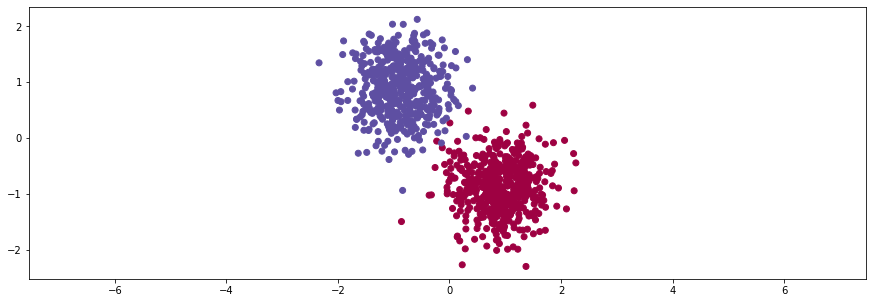

In [7]:
N = 1000

X, y = make_blobs(
    n_samples=N, n_features=50, centers=2, cluster_std=3.0, random_state=seed
)
X = scaler.fit_transform(X)

y[y != 1] = -1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
plt.axis("equal")
plt.show()

N_new = 100
X_new, y_new = make_blobs(
    n_samples=N_new, n_features=50, centers=2, cluster_std=3.0, random_state=seed + 1
)
X_new = scaler.transform(X_new)


Se representa el embedding de Diffusion Maps para $T=\alpha=1$ con un núcleo gaussiano variando el parámetro $\sigma$.

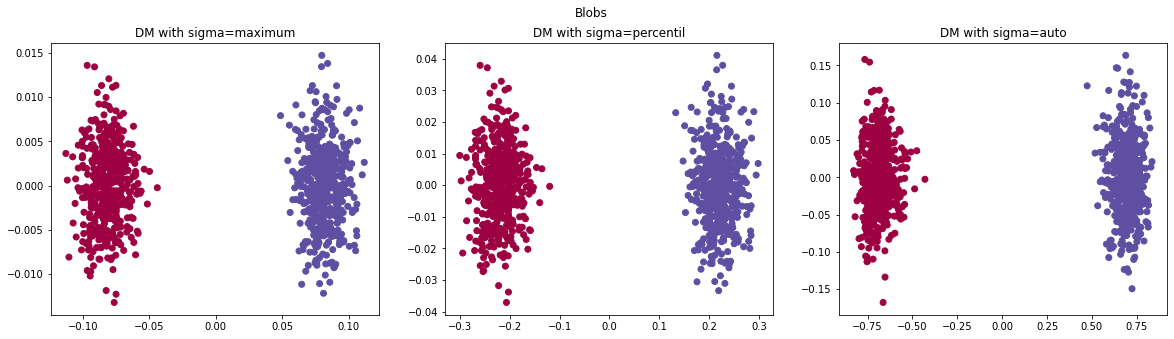

In [8]:
sigma_parameters = ['maximum', 'percentil', 'auto']
dm_alpha = [DM(sigma = sigma) for sigma in sigma_parameters]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Blobs')
for i, dm_alpha in enumerate(dm_alpha):
    X_red = dm_alpha.fit_transform(X)
    axes[i].scatter(X_red[:, 0], X_red[:, 1], c=y, cmap=my_cmap)
    axes[i].set_title(f'DM with sigma={sigma_parameters[i]}')

Observamos que la única diferencia notable en los datos es la distancia entre ambas clases, siendo mayor para $\sigma=$auto.
A continuación, se representa el embedding con $\sigma=$maximum  utilizando la aproximación de Nystrom para datos no observados. 

Sigma: 16.315177428252188


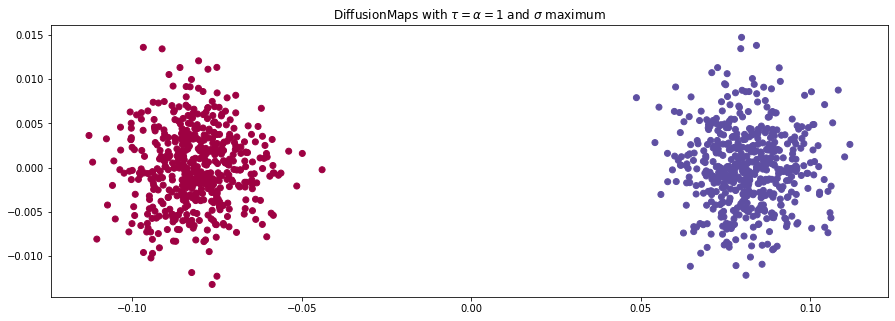

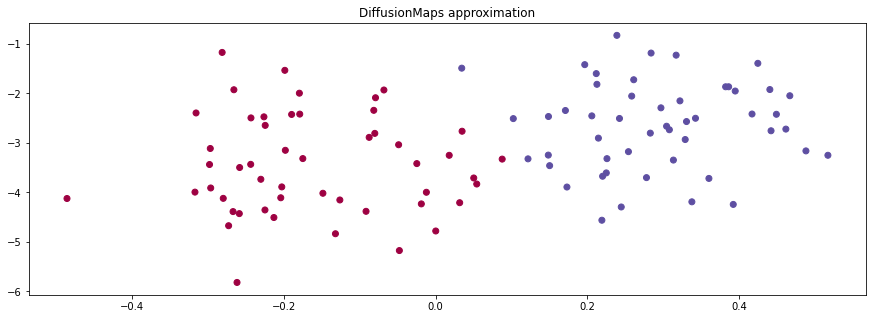

In [9]:
dm = DM(sigma = 'maximum')
X_red = dm.fit_transform(X)
print('Sigma:', dm.sigma_)

plt.scatter(X_red[:, 0], X_red[:, 1], c=y, cmap=my_cmap)
plt.title(r"DiffusionMaps with $\tau=\alpha=1$ and $\sigma$ maximum")
plt.show()

X_red_new = dm.transform(X_new)

plt.scatter(X_red_new[:, 0], X_red_new[:, 1], c=y_new, cmap=my_cmap)
plt.title(r"DiffusionMaps approximation")
plt.show()

Observamos en la primera figura el embedding obtenido para los datos de entrenamiento. Vemos como las clases son linealmente separables, encontrando un margen de separación bastante grande.

Para los nuevos datos, las clases no son linealmente separables. Si se utiliza un margen muy estrecho, vemos que uno de los puntos azules pertenecería a la clase roja. Sin embargo, podemos concluir que se trata de un buen embedding para datos no observados, ya que la separación lineal es casi perfecta. 

## Dataset 2: the swiss roll

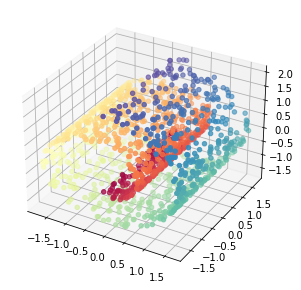

In [10]:
N = 1500
X, color = make_swiss_roll(n_samples=N, random_state=seed)
X = scaler.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=my_cmap)
plt.show()

N_new = 100
X_new, color_new = make_swiss_roll(n_samples=N_new, random_state=seed + 1)
X_new = scaler.transform(X_new)

A continuación, se representa el embedding de Diffusion Maps para $T=\alpha=1$ con un núcleo gaussiano variando el parámetro $\sigma$.

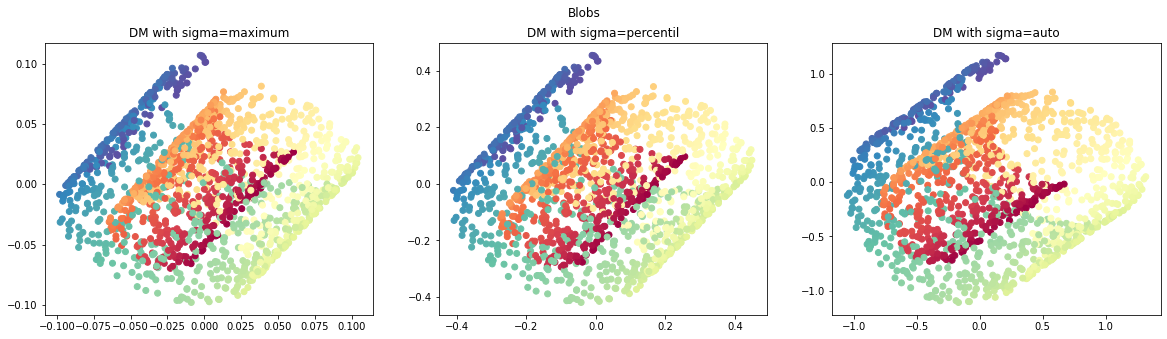

In [11]:
sigma_parameters = ['maximum', 'percentil', 'auto']
dm_alpha = [DM(sigma = sigma) for sigma in sigma_parameters]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Blobs')
for i, dm_alpha in enumerate(dm_alpha):
    X_red = dm_alpha.fit_transform(X)
    axes[i].scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
    axes[i].set_title(f'DM with sigma={sigma_parameters[i]}')

No se obtienen buenos embedding debido a la elección del parámetro sigma. La estructura geométrica de los datos ahora es más complicada y necesitamos que el embedding utilice información muy local. Por ese motivo, centraremos la elección de $\sigma$ variando el percentil seleccionado.

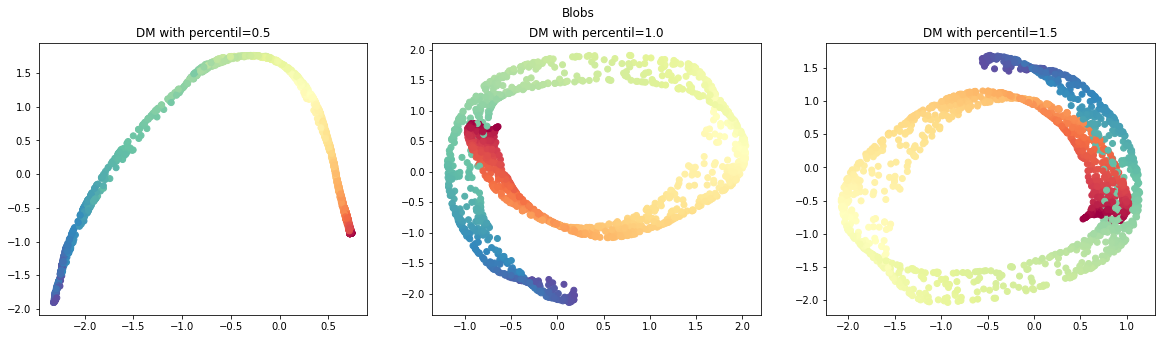

In [12]:
percentil_parameters = np.linspace(0.5, 1.5, 3)
dm_percentil = [DM(percentil = percentil) for percentil in percentil_parameters]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Blobs')
for i, dm_percentil in enumerate(dm_percentil):
    X_red = dm_percentil.fit_transform(X)
    axes[i].scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
    axes[i].set_title(f'DM with percentil={percentil_parameters[i]}')

Observamos que el mejor embedding se obtiene para el percentil 0.5. Para el resto de percentiles, las clases se solapan y no se ha conseguido eliminar la estructura enrollada de los datos.

Finalmente, para el embedding que utiliza el percentil 0.5, utilizando Nystrom se aproximan los datos no observados.

Sigma: 0.24481075628410023


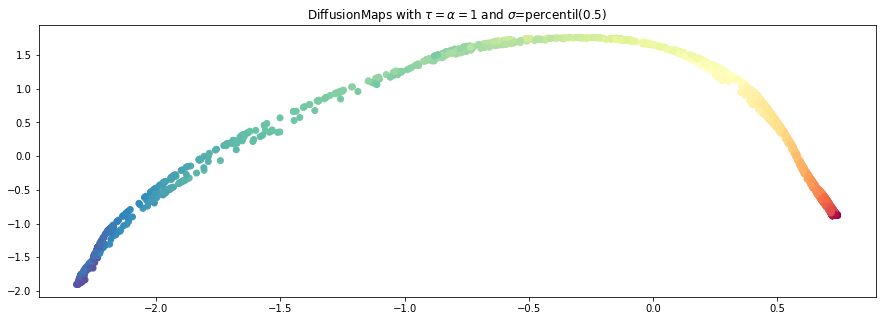

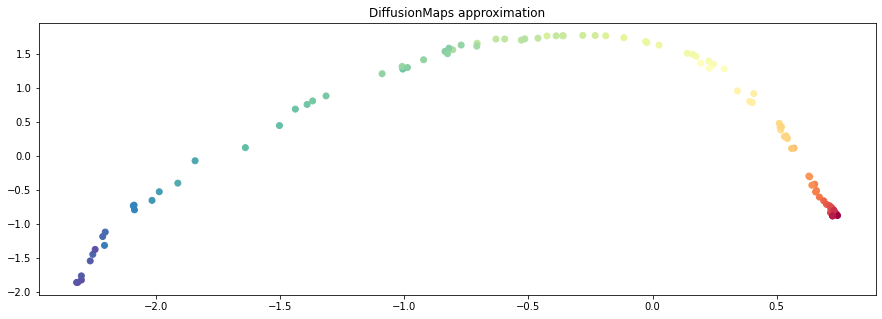

In [13]:
dm = DM(percentil = 0.5)
X_red = dm.fit_transform(X)
print('Sigma:', dm.sigma_)

plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.title(r'DiffusionMaps with $\tau=\alpha=1$ and $\sigma$=percentil(0.5)')
plt.show()

X_red_new = dm.transform(X_new)

plt.scatter(X_red_new[:, 0], X_red_new[:, 1], c=color_new, cmap=my_cmap)
plt.title(r'DiffusionMaps approximation')
plt.show()

Si bien en el embedding obtenido para los datos de entrenamiento vemos como se preservan las distancias entre vecinos y podemos distinguir claramente las clases, no se consigue 'desenrollar' la espiral y obtener una banda con las clases separadas. Para los datos no observados, vemos que Nystrom consigue una buena aproximación al embedding original.


A continuación, comparamos el embedding al utilizar un núcleo Laplaciano.

Sigma: 0.24481075628410023


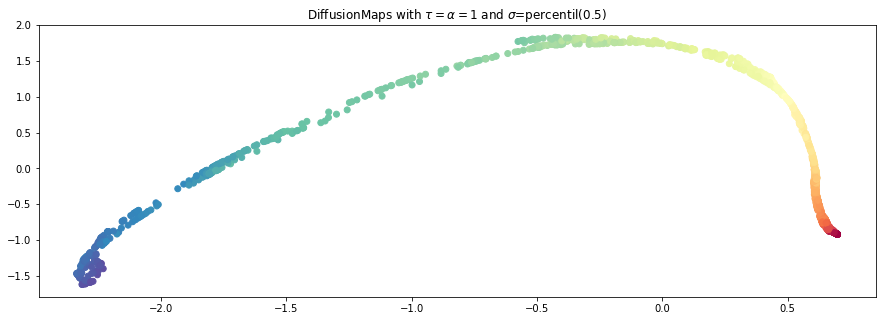

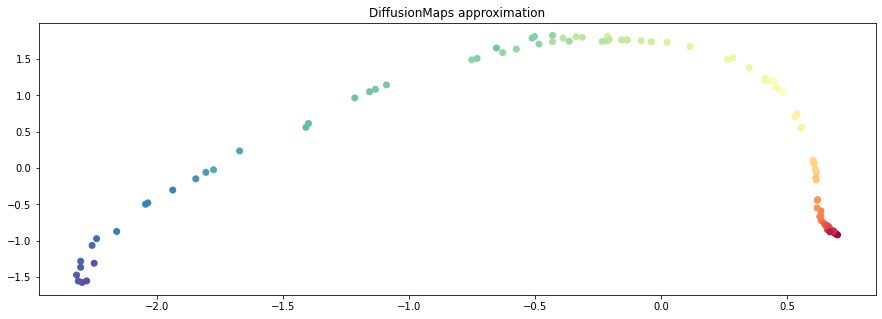

In [14]:
dm = DM(percentil = 0.5, kernel_type = 'laplacian')
X_red = dm.fit_transform(X)
print('Sigma:', dm.sigma_)

plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.title(r'DiffusionMaps with $\tau=\alpha=1$ and $\sigma$=percentil(0.5)')
plt.show()

X_red_new = dm.transform(X_new)

plt.scatter(X_red_new[:, 0], X_red_new[:, 1], c=color_new, cmap=my_cmap)
plt.title('DiffusionMaps approximation')
plt.show()

Vemos que ambos embedding apenas difieren. 

## Dataset 3: the S curve

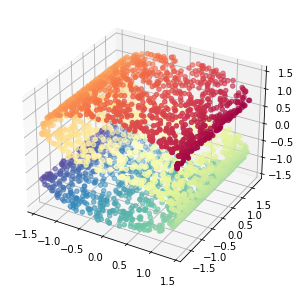

In [15]:
N = 3000
X, color = make_s_curve(N, random_state=seed)
X = scaler.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=my_cmap)
plt.show()

N_new = 100
X_new, color_new = make_s_curve(N_new, random_state=seed + 1)
X_new = scaler.transform(X_new)


Al igual que con el conjunto de datos anterior, representamos el embedding de Diffusion Maps para $T=\alpha=1$ con un núcleo gaussiano variando el parámetro percentil en lugar de variando el parámetro sigma ya que interesa mantener la información local de los datos.

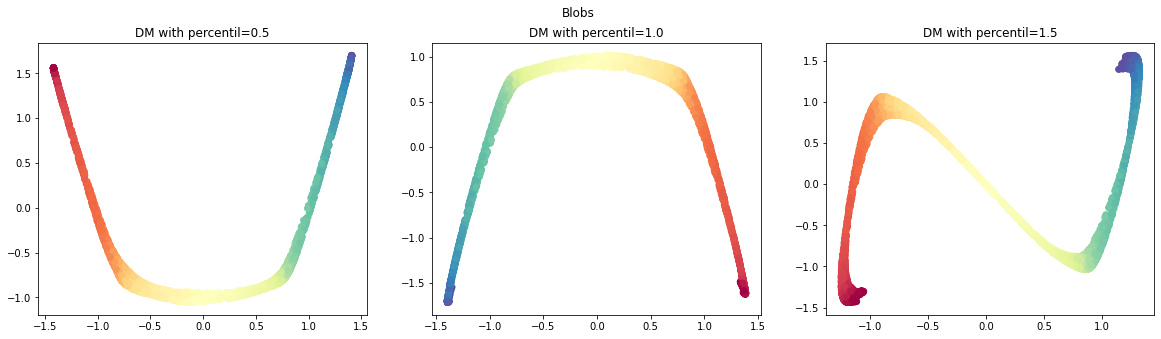

In [16]:
percentil_parameters = np.linspace(0.5, 1.5, 3)
dm_percentil = [DM(percentil = percentil) for percentil in percentil_parameters]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Blobs')
for i, dm_percentil in enumerate(dm_percentil):
    X_red = dm_percentil.fit_transform(X)
    axes[i].scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
    axes[i].set_title(f'DM with percentil={percentil_parameters[i]}')

Para las dos primeras elecciones de percentiles observamos que se obtiene el mismo embedding invertido. En el último embedding vemos que se mantiene la forma de 'S' de los datos.

Ilustraremos el embedding original y el aproximado para el núcleo gaussiano con el parámetro percentil = 1.0 y finalmente el núcleo laplaciano con este mismo parámetro. 

Sigma: 0.3329754101704055


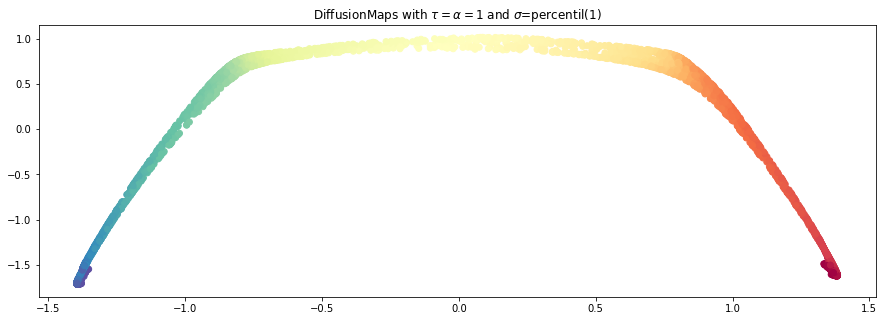

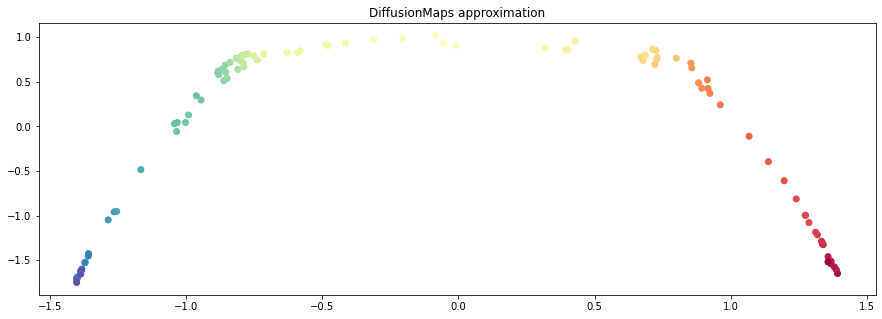

In [17]:
dm = DM(percentil = 1)
X_red = dm.fit_transform(X)
print('Sigma:', dm.sigma_)

plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.title(r'DiffusionMaps with $\tau=\alpha=1$ and $\sigma$=percentil(1)')
plt.show()

X_red_new = dm.transform(X_new)

plt.scatter(X_red_new[:, 0], X_red_new[:, 1], c=color_new, cmap=my_cmap)
plt.title('DiffusionMaps approximation')
plt.show()

Sigma: 0.3329754101704055


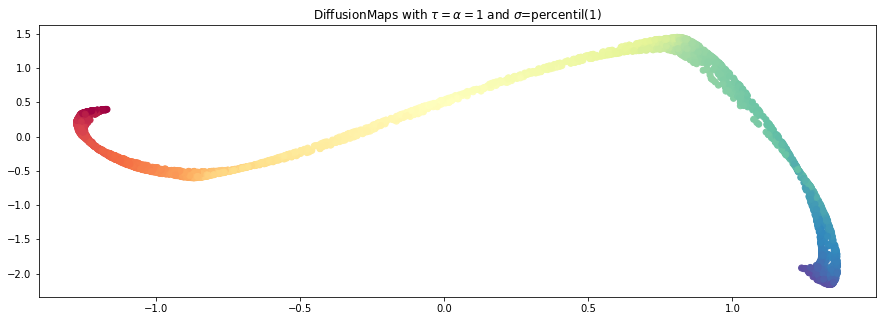

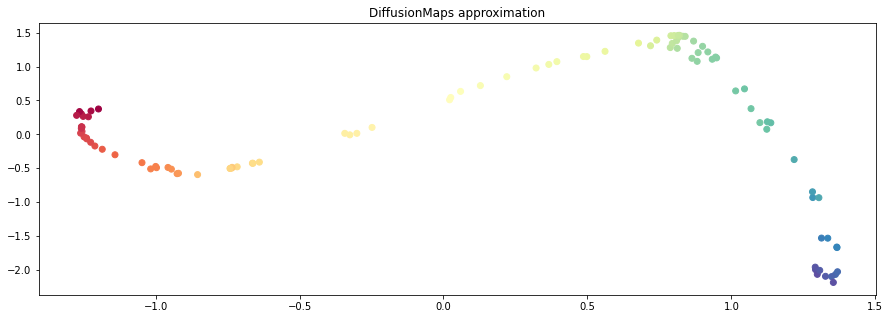

In [18]:
dm = DM(percentil = 1, kernel_type='laplacian')
X_red = dm.fit_transform(X)
print('Sigma:', dm.sigma_)

plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.title(r'DiffusionMaps with $\tau=\alpha=1$ and $\sigma$=percentil(1)')
plt.show()

X_red_new = dm.transform(X_new)

plt.scatter(X_red_new[:, 0], X_red_new[:, 1], c=color_new, cmap=my_cmap)
plt.title('DiffusionMaps approximation')
plt.show()

En este caso, el embedding obtenido por el núcleo Laplaciano difiese del gaussiano debido a la elección de $\sigma$. En ambos caso no obtenemos una banda desenrollada de las clases. Utilizando el núcleo laplaciano se observa más la geometría de la 'S' inicial en el embedding y con el núcleo gaussiano se consigue desenrollar la 'S' mejor. Respecto al embedding utilizando Nystrom, ambos consiguen una buena aproximación.  

<div class="qst">

1. Do you consider that the embedding obtained is good for the previous datasets? Is it the expected one? Why?
    
    
2. How sensible is the method to its hyper-parameters? Specify the best values that you have found and the technique employed for it.
    * Check how much influence the sample density (you can vary N for each dataset).
    * Check what happens if the number of steps `steps` grows.
   
    
3. In your opinion, which is the main advantage and disadvantage of this method?
    
</div>

**Answer**:

1. Para el primer conjunto de datos, el embedding obtenido era correcto y esperado ya que las distancias entre clases en el embedding son mayores. Por otro lado, el embedding para datos no observados no es tan preciso y las clases no están tan separadas. Para el conjunto de datos del swiss roll, no encontramos ningún conjunto de parámetros que consiga desenrollar los datos. Aún así, el embedding obtenido permite distinguir cada clase utilizando una dimensión menor. Respecto al embedding de datos no observados, vemos que Nystrom consigue aproximar el embedding original correctamente y obtener una separación de clases con la misma estructura y distancias. Finalmente, para el último conjunto de datos ocurre algo similar al anterior tanto para el conjunto de entrenamiento como para los datos no observados. No conseguimos desenrollar la curva 'S', pero se obtiene un embedding en el que se distinguen correctamente las clases. 


2. Hemos observado que el método es sobre todo sensible al parámetro $\sigma$ del núcleo elegido, ya que es el parámetro que mide la cantidad de información local utilizada en el embedding. Además, la elección de mediana o máximo para elegir $\sigma$ es excesiva para los dos últimos conjuntos de datos con geometrías más complicadas. Para estos conjuntos, una elección basada en percentiles bajos ($\sigma<1$) obtiene mejores resultados. Respecto al núcleo Laplaciano o núcleo gaussiano no encontramos diferencias significativas. Respecto a los parámetros de densidad $\alpha$ y número de pasos en el grafo $T$, a continuación se realiza el análisis fijando el núcleo gaussiano y el parámetro $\alpha$ que mejor embedding había obtenido en el ejercicio 1.


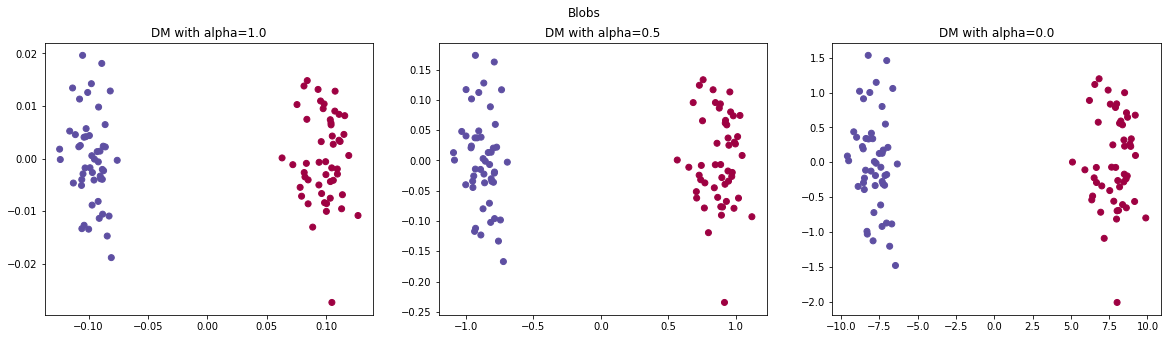

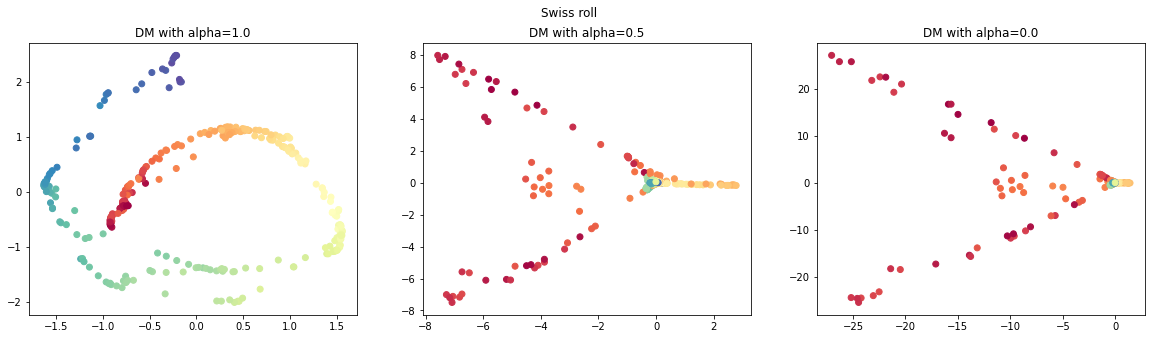

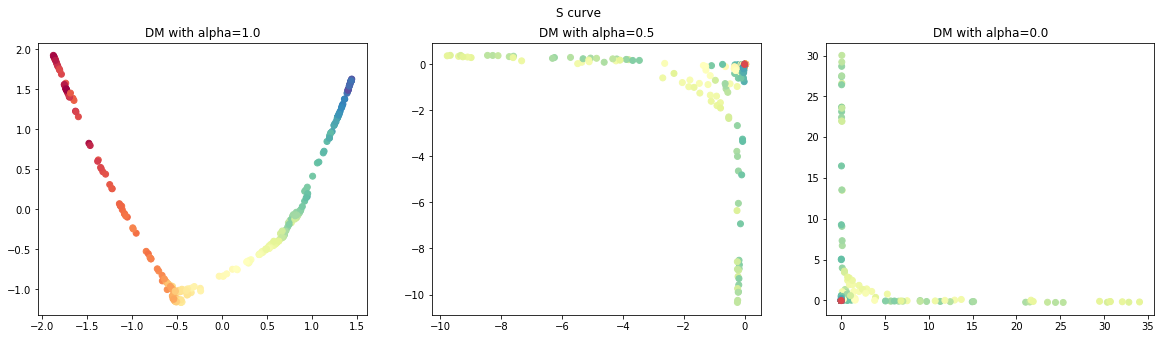

In [19]:
alpha_parameters = [1.0, 0.5, 0.0]


# Blobs
N = 100
X, y = make_blobs(n_samples=N, n_features=50, centers=2, cluster_std=3.0, random_state=seed + 1)
X = scaler.fit_transform(X)
dm_alpha = [DM(sigma = 'maximum', alpha=alpha) for alpha in alpha_parameters]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Blobs')
for i, dm_alpha in enumerate(dm_alpha):
    X_red = dm_alpha.fit_transform(X)
    axes[i].scatter(X_red[:, 0], X_red[:, 1], c=y, cmap=my_cmap)
    axes[i].set_title(f'DM with alpha={alpha_parameters[i]}')

# Swiss roll
N = 300
X, color = make_swiss_roll(n_samples=N, random_state=seed)
X = scaler.fit_transform(X)
dm_alpha = [DM(percentil = 1, alpha=alpha) for alpha in alpha_parameters]
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Swiss roll')
for i, dm_alpha in enumerate(dm_alpha):
    X_red = dm_alpha.fit_transform(X)
    axes[i].scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
    axes[i].set_title(f'DM with alpha={alpha_parameters[i]}')

# S curve
N = 300
X, color = make_s_curve(N, random_state=seed)
X = scaler.fit_transform(X)
dm_alpha = [DM(percentil = 1, alpha=alpha) for alpha in alpha_parameters]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('S curve')
for i, dm_alpha in enumerate(dm_alpha):
    X_red = dm_alpha.fit_transform(X)
    axes[i].scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
    axes[i].set_title(f'DM with alpha={alpha_parameters[i]}')

La influencia de parámetro $\alpha$ permite controlar la influencia de la densidad de la muestra. Este control es importante ya que cuando el muestreo de la variedad no es uniforme y no se muestrea un número suficiente de datos, el método Diffusion Maps puede no recuperar la geometría original de los datos. Cuando $\alpha=1$, Diffusion Maps captura la geometría subyacente sin interferir en la densidad de la muestra, mientras que cuando $\alpha=0$, la influencia es muy fuerte a menos que la densidad sea uniforme. 

Las imagénes anteriores muestran la influencia de $\alpha$ en los 3 conjuntos de datos cuando no disponemos de un gran número de muestras:

- **Blobs**: $\alpha$ solo influye en un escalado de los datos, ya que la geometría en ese ejemplo es muy sencilla.
- **Swiss roll**: con $\alpha=1$, DM no consigue un buen embedding al disponer de tan pocos datos. Por tanto, al aumentar la influencia de la densidad de datos cuando disminuimos $\alpha$, vemos que el embedding es cada vez peor y solo representa la primera clase, agrupando el resto de clases en 0.
- **S curve**: mismo análisis que en Swiss roll. 


A continuación, analizamos la influencia del parámetro $T$.

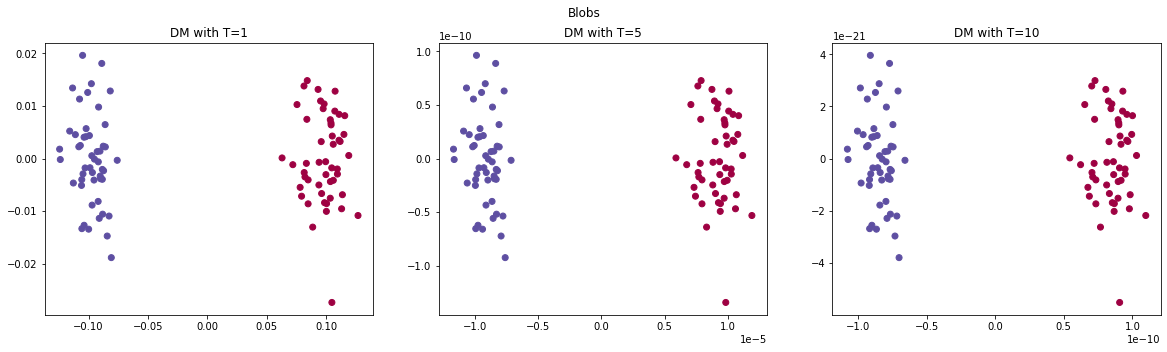

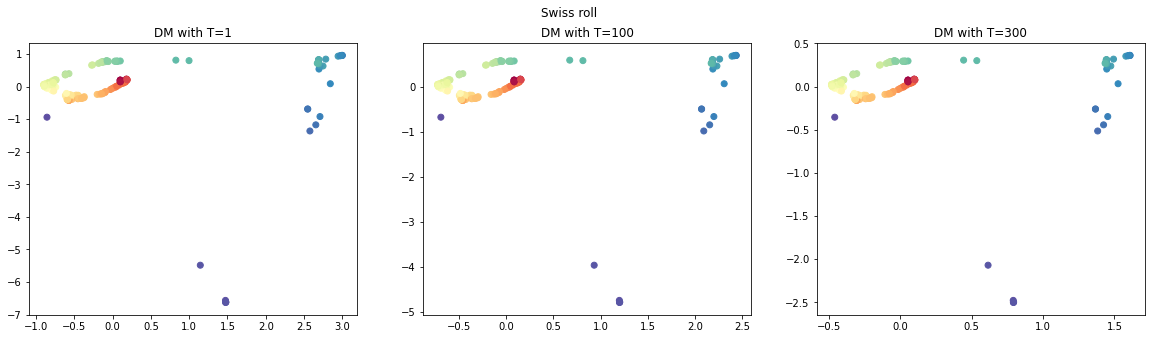

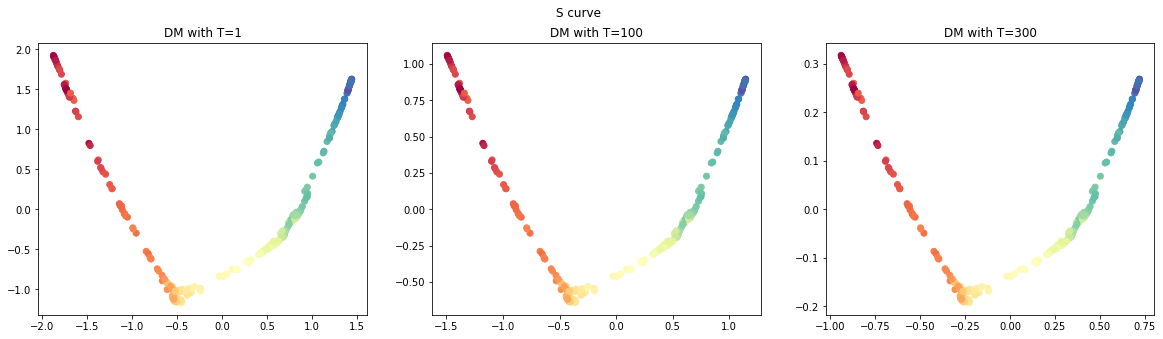

In [20]:
# Blobs
N = 100
X, y = make_blobs(n_samples=N, n_features=50, centers=2, cluster_std=3.0, random_state=seed + 1)
X = scaler.fit_transform(X)

step_parameters = [1, 5, 10]

dm_step = [DM(sigma = 'maximum', step=step) for step in step_parameters]
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Blobs')
for i, dm_alpha in enumerate(dm_step):
    X_red = dm_alpha.fit_transform(X)
    axes[i].scatter(X_red[:, 0], X_red[:, 1], c=y, cmap=my_cmap)
    axes[i].set_title(f'DM with T={step_parameters[i]}')

# Swiss roll
N = 200
X, color = make_swiss_roll(n_samples=N, random_state=seed)
X = scaler.fit_transform(X)

step_parameters = [1, 100, 300]


dm_step = [DM(percentil = 1, step=step) for step in step_parameters]
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Swiss roll')
for i, dm_alpha in enumerate(dm_step):
    X_red = dm_alpha.fit_transform(X)
    axes[i].scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
    axes[i].set_title(f'DM with T={step_parameters[i]}')

# S curve
N = 300
X, color = make_s_curve(N, random_state=seed)
X = scaler.fit_transform(X)

step_parameters = [1, 100, 300]


dm_step = [DM(percentil = 1, step=step) for step in step_parameters]
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('S curve')
for i, dm_alpha in enumerate(dm_step):
    X_red = dm_alpha.fit_transform(X)
    axes[i].scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
    axes[i].set_title(f'DM with T={step_parameters[i]}')

El parámetro $T$ es el número de pasos en el grafo de difusión, y controla la cantidad de componentes relevantes en el embedding: 

$$X_{red} = \lambda^{T}\psi.$$

Es decir, a medida que aumenta $T$, la diferencia entre los autovalores aumenta, de manera que las últimas componentes son cada vez más insignificantes. 

De hecho, si observamos las imágenes de arriba, vemos que la estructura geométrica del embedding se mentiene y que solo difieren en la escala, siendo cada vez menor. Además, para notar esta diferecia significativa en el escalado es necesario aumentar el número de pasos en el escalado.



3. En nuestra opinión, la principal ventaja de este método es que se modela utilizando procesos de Markov, lo que permite otorgar una estructura temporal a los datos. Además, el parámetro de difusión permite controlar la influencia de la densidad de las muestras, lo que hace el método más versatil. También presenta todos las ventajas de los algoritmos basados en variedades, que asumen que los datos viven en variedades no lineales de dimensión menor en las que se preservan las distancias entre puntos cercanos y puntos lejanos. Como principal inconveniente, ambos miembros de la pareja coincidimos que es el alto coste computacional que supone tanto volver a computar la matriz de afinidad para datos no observados utilizando la aproximación de Nystrom como en la búsqueda de hiperparámetros.